# F1 - Train Machine Learning Models
Develop a machine learning model to predict if an F1 driver will be on the podium, in the points, or not in the points.

Model registry logic follows the guide from Snowflake here:<br>
https://github.com/Snowflake-Labs/sfguide-intro-to-machine-learning-with-snowpark-ml-for-python/blob/main/3_snowpark_ml_model_training_inference.ipynb

### Steps
1. Read in the data from the `fct_results` table in Snowflake (built by dbt). 
2. Preprocess the data using a pipeline already saved in a Snowflake Stage.
3. Split the data into training and test sets.
4. Develop and train the machine learning models using the training set.
5. Evaluate the models using the test data.
6. Save the models to the Snowflake Stage so it can be called by a downstream dbt Python model.

### Imports

In [1]:
import os
import warnings
from pprint import pprint

import joblib
import pandas as pd
import seaborn as sns

# import snowflake.ml.modeling.preprocessing as snowml
from dotenv import load_dotenv
from snowflake.ml.modeling.metrics import accuracy_score
from snowflake.ml.modeling.model_selection.grid_search_cv import GridSearchCV

# from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.registry import registry
from snowflake.snowpark import Session
from snowflake.snowpark import functions as F

# from snowflake.snowpark import types as T
from snowflake.snowpark.version import VERSION as SNOWPARK_VERSION

warnings.simplefilter("ignore")

#### Constants

In [2]:
# Get environment variables from .env file. This file is not committed to git.
# It should contain the following variables:
#   SNOWFLAKE_ACCOUNT=<account_name>
#   SNOWFLAKE_ML_USER=<username>
#   SNOWFLAKE_ML_PASSWORD=<password>

load_dotenv()  # Get environment variables from .env file

# Connection
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")  # From .env file
DATABASE = "FORMULA1"
WAREHOUSE = "TRANSFORMING"
ROLE = "TRANSFORMER"
DEV_SCHEMA = "DBT_GREG"  # Replace with dev schema storing feature data
USER = os.getenv("SNOWFLAKE_ML_USER")  # From .env file
PASSWORD = os.getenv("SNOWFLAKE_ML_PASSWORD")  # From .env file


# Snowflake Stage and Pipeline file
ML_SCHEMA = "ML"
ML_STAGE = "F1_STAGE"
PIPELINE_FILE = "f1_preprocess_pipeline.joblib"

# Features
INDEX = ["RESULT_ID"]  # For joins later
FEATURES = [
    "RACE_YEAR",
    "CIRCUIT_NAME",
    "GRID",
    "CONSTRUCTOR_NAME",
    "DRIVER",
    "DRIVERS_AGE_YEARS",
    "DRIVER_CONFIDENCE",
    "CONSTRUCTOR_RELIABILITY",
    "TOTAL_PIT_STOPS_PER_RACE",
]
TARGET = ["POSITION_LABEL"]  # 1 = podium, 2 = points, 3 = no points

### Get Data from Snowflake

In [3]:
# Create a Snowflake session
session = Session.builder.configs(
    {
        "account": ACCOUNT,
        "database": DATABASE,
        "warehouse": WAREHOUSE,
        "role": ROLE,
        "schema": DEV_SCHEMA,
        "user": USER,  #
        "password": PASSWORD,
    }
).create()
session.sql_simplifier_enabled = True
snowflake_env = session.sql("select current_user(), current_version()").collect()

pprint("Connected to Snowflake with the following parameters:")
pprint(f"User: {snowflake_env[0][0]}")
pprint(f"Role: {session.get_current_role()}")
pprint(f"Database: {session.get_current_database()}")
pprint(f"Warehouse: {session.get_current_warehouse()}")
pprint(f"Schema: {session.get_current_schema()}")
pprint(f"Snowflake version: {snowflake_env[0][1]}")
pprint(
    f"Snowpark for Python version: {SNOWPARK_VERSION[0]}.{SNOWPARK_VERSION[1]}.{SNOWPARK_VERSION[2]}"
)

'Connected to Snowflake with the following parameters:'
'User: GREG_CLUNIES'
'Role: "TRANSFORMER"'
'Database: "FORMULA1"'
'Warehouse: "TRANSFORMING"'
'Schema: "DBT_GREG"'
'Snowflake version: 8.8.4'
'Snowpark for Python version: 1.11.1'


In [4]:
table_df = session.table("F1_FEATURES")
table_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RESULT_ID"  |"RACE_ID"  |"RACE_YEAR"  |"CIRCUIT_ID"  |"CIRCUIT_NAME"         |"CIRCUIT_REF"  |"LOCATION"    |"COUNTRY"  |"LATITUDE"  |"LONGITUDE"  |"ALTITUDE"  |"TOTAL_PIT_STOPS_PER_RACE"  |"RACE_DATE"  |"RACE_TIME"  |"DRIVER_ID"  |"DRIVER"          |"DRIVER_NUMBER"  |"DRIVERS_AGE_YEARS" 

In practice, you would train a model on a given set of data, splitting it into train and test sets. Then, you would use the model to make predictions on entirely new data as it arrives in your data warehouse. 

This demo has now way for new F1 data to arrive, so we will simulate this by training our model on data from 2010 to 2019 and then making predictions on the 2020 data.

In [5]:
features_df = table_df.select(INDEX + TARGET + FEATURES)
features_df.show(10)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RESULT_ID"  |"POSITION_LABEL"  |"RACE_YEAR"  |"CIRCUIT_NAME"         |"GRID"  |"CONSTRUCTOR_NAME"  |"DRIVER"          |"DRIVERS_AGE_YEARS"  |"DRIVER_CONFIDENCE"  |"CONSTRUCTOR_RELIABILITY"  |"TOTAL_PIT_STOPS_PER_RACE"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|20325        |0                 |2010         |BAHRAIN_GRAND_PRIX     |4       |MCLAREN             |LEWIS_HAMILTON    |25                   |0.911215             |0.855491                   |0                           |
|20326        |1                 |2010         |BAHRAIN_GRAND_PRIX     |1       |RED_BULL            |SEBAST

### Prepare the Data for ML model
Prepare the features data for use in ML models using the preprocessing pipeline defined in the `f1_preprocess_pipeline.ipynb` notebook. This preprocessing pipeline performs:
- Normalization of numerical features
- One hot encoding of categorical features

In [6]:
# Get and load the preprocessing pipeline
session.file.get(f"@{ML_SCHEMA}.{ML_STAGE}/{PIPELINE_FILE}.gz", ".")
preprocess_pipeline = joblib.load(f"{PIPELINE_FILE}.gz")

In [7]:
processed_df = preprocess_pipeline.fit(features_df).transform(features_df)
processed_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Drop the original features, only keeping the normalized and one hot encoded features.

In [8]:
data_df = processed_df.drop(FEATURES)  # Keep normalized and encoded features only
data_df = data_df.select(  # Cleanup column order
    F.col("RESULT_ID"),
    F.col("POSITION_LABEL"),
    F.sql_expr("* exclude(RESULT_ID, POSITION_LABEL)"),
)
data_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Split Data into Training and Test Sets

In [9]:
# Data is fairly small, so test split is 40% to get a race from all circuits
train_df, test_df = data_df.random_split([0.6, 0.4], seed=0)

### Develop ML Model
We will build a classification model to predict whether an F1 driver will be on the podium, in the points, or not in the points.

We'll use the Snowpark `XGBClassifier` model and tune it's parameters using `GridSearchCV`. Both are optimized for Snowflake.

#### Hyperparameter Tuning & Training

In [10]:
TARGET = ["POSITION_LABEL"]
PREDICTED_TARGET = ["PREDICTED_POSITION_LABEL"]
NOT_FEATURES = INDEX + TARGET
FEATURES = [col for col in data_df.columns if col not in NOT_FEATURES]

# Tune an XGB Classifier model using sklearn GridSearchCV.
grid_search_cv = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        "n_estimators": [25, 50, 75, 100, 125, 150, 175, 200],
        "learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05],
    },
    n_jobs=-1,  # Use all available cores
    scoring="accuracy",
    input_cols=FEATURES,
    label_cols=TARGET,
    output_cols=PREDICTED_TARGET,
    passthrough_cols=INDEX,
)

grid_search_cv.fit(train_df)

We can use `to_sklearn()` to get the XGBoost model object and its attributes/methods. 

Let's analyze the grid search results to understand the best hyperparameters for the model.

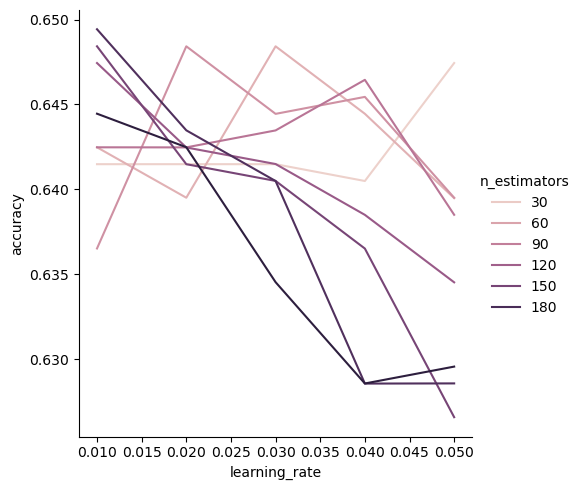

In [11]:
gs_results = grid_search_cv.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []

for params in gs_results["params"]:
    n_estimators_val.append(params["n_estimators"])
    learning_rate_val.append(params["learning_rate"])

accuracy = gs_results["mean_test_score"]
accuracy
gs_result_df = pd.DataFrame(
    data={
        "n_estimators": n_estimators_val,
        "learning_rate": learning_rate_val,
        "accuracy": accuracy,
    },
)

sns.relplot(
    data=gs_result_df, x="learning_rate", y="accuracy", hue="n_estimators", kind="line"
)

In [12]:
grid_search_cv.to_sklearn().best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

It looks like the best performing hyperparameters are:
- `learnig_rate` = 0.01
- `n_estimators` = 175

Accuracy is approximately 65%.

Could the model be imporved? Almost certainly. But for the sake of this demo, we'll leave that for another time.

### Making Predictions

Now that we've trained a model, let's make predictions using the test set.

In [13]:
# Predict on test data
predict_df = grid_search_cv.predict(test_df)

# Analyze the results
accuracy = accuracy_score(
    df=predict_df, y_true_col_names=TARGET[0], y_pred_col_names=PREDICTED_TARGET[0]
)
predict_df.select(TARGET[0], PREDICTED_TARGET[0]).show()

predict_df.show()
print(f"Accuracy Score: {accuracy}")

-------------------------------------------------
|"POSITION_LABEL"  |"PREDICTED_POSITION_LABEL"  |
-------------------------------------------------
|0                 |0.0                         |
|1                 |2.0                         |
|2                 |2.0                         |
|1                 |1.0                         |
|2                 |1.0                         |
|0                 |0.0                         |
|1                 |1.0                         |
|1                 |2.0                         |
|1                 |1.0                         |
|1                 |2.0                         |
-------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We can plot the predicted values against the actual values to help visualize how well our model performs.

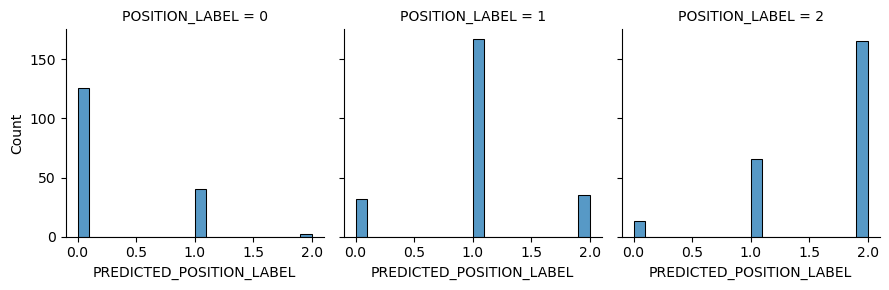

In [14]:
# Plot actual vs predicted
g = sns.FacetGrid(predict_df.toPandas(), col="POSITION_LABEL", col_wrap=3)
g.map(sns.histplot, PREDICTED_TARGET[0], bins=20)

### Deploy Model using Model Registry
With a trained model, it's time to deploy the model to Snowflake's Model Registry so that we can call it in a downstream dbt model. This will make our prediction process part of the dbt DAG!

### Model Metadata
First, let' get some metadata about the model.

In [15]:
optimal_model = grid_search_cv.to_sklearn().best_estimator_
optimal_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=175, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [16]:
optimal_n_estimators = grid_search_cv.to_sklearn().best_params_["n_estimators"]
optimal_learning_rate = grid_search_cv.to_sklearn().best_params_["learning_rate"]

optimal_accuracy = gs_result_df.loc[
    (gs_result_df["n_estimators"] == optimal_n_estimators)
    & (gs_result_df["learning_rate"] == optimal_learning_rate),
    "accuracy",
].values[0]

pprint(f"Optimal n_estimators: {optimal_n_estimators}")
pprint(f"Optimal learning_rate: {optimal_learning_rate}")
pprint(f"Optimal accuracy: {optimal_accuracy}")

'Optimal n_estimators: 175'
'Optimal learning_rate: 0.01'
'Optimal accuracy: 0.6494310625092361'


### Log Model to Registry

In [17]:
# Define model name
MODEL_NAME = "F1_XGB_MODEL"

Create a model registry that will be used to log the model.

In [18]:
# Create a model registry
native_registry = registry.Registry(
    session=session,
    database_name=DATABASE,
    schema_name=ML_SCHEMA,
    # create_if_not_exists=True,
)

Log the model to the registry, adding metric metadata and comments to the model.

In [20]:
# Get sample input data to pass into the registry logging function
X = train_df.select(FEATURES)

# I HAVE ALREADY LOGGED MULTIPLE MODELS TO THE REGISTRY, SO I AM COMMENTING OUT THE CODE BELOW

# # Log model to registry
# model_ver0 = native_registry.log_model(
#     model_name=MODEL_NAME,
#     version_name="V0",
#     model=optimal_model,
#     sample_input_data=X,  # To provide the feature schema
# )

# model_ver0.set_metric(metric_name="accuracy", value=optimal_accuracy)
# model_ver0.comment = "XGBoost model for predicting F1 driver position"

# # Log model to registry
# model_ver1 = native_registry.log_model(
#     model_name=MODEL_NAME,
#     version_name="V1",
#     model=optimal_model,
#     sample_input_data=X,  # To provide the feature schema
# )

# model_ver1.set_metric(metric_name="accuracy", value=optimal_accuracy)
# model_ver1.comment = "XGBoost model for predicting F1 driver position"

# Log model to registry
# model_ver2 = native_registry.log_model(
#     model_name=MODEL_NAME,
#     version_name="V2",
#     model=optimal_model,
#     sample_input_data=X,  # To provide the feature schema
# )

# model_ver2.set_metric(metric_name="accuracy", value=optimal_accuracy)
# model_ver2.comment = "XGBoost model for predicting F1 driver position"

# Log model to registry
model_ver3 = native_registry.log_model(
    model_name=MODEL_NAME,
    version_name="V3",
    model=optimal_model,
    sample_input_data=X,  # To provide the feature schema
)

model_ver3.set_metric(metric_name="accuracy", value=optimal_accuracy)
model_ver3.comment = "XGBoost model for predicting F1 driver position"

You can create multiple versions of the same model in the Model Registry. This is useful for tracking the performance of the model over time.

Let's see all model versions in the Model Registry.

In [23]:
native_registry.get_model(MODEL_NAME).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-02-26 20:57:07.935000-08:00,V0,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,true,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6414807152357026}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."
1,2024-02-26 21:01:18.215000-08:00,V1,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,false,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6414807152357026}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."
2,2024-02-27 22:28:00.283000-08:00,V2,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,false,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6494310625092361}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."
3,2024-03-03 08:44:09.928000-08:00,V3,XGBoost model for predicting F1 driver position,FORMULA1,ML,F1_XGB_MODEL,false,"[""PREDICT_PROBA"",""PREDICT"",""APPLY""]","{""metrics"": {""accuracy"": 0.6494310625092361}, ...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."


Every model in the registry has a default version.

### Call Model From Registry to Make Predictions

In [22]:
# Make predictions using the test data
model_ver = native_registry.get_model(MODEL_NAME).version("v3")
predict_df = model_ver.run(test_df, function_name="predict")

In [24]:
# Renam the prediction column to something more meaningful
final_df = predict_df.rename(F.col('"output_feature_0"'), "PREDICTED_POSITION_LABEL")
final_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### OPTIONAL - Cleanup

We can also delete models from the registry if we want to.

In [ ]:
# native_registry.delete_model(model_name)  # Uncomment to run and delete the model
# native_registry.show_models()